151307 156415
154301 156415
157892 156415
159287 156415
160385 156415
161576 156415
179542 156415
107207 134812
134390 134812
146634 134812
152269 134812
158735 134812
166709 134812
227790 134812
12840 10088
15804 10088
17332 10088
18107 10088
19034 10088
20658 10088
52533 10088
3208 4189
3403 4189
3643 4189
3709 4189
3744 4189
3784 4189
4181 4189


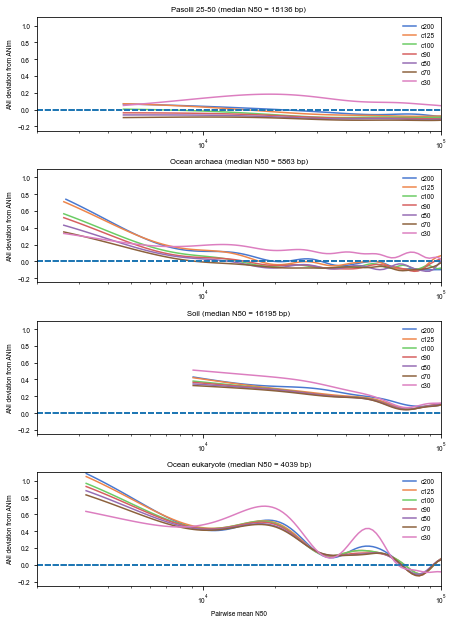

In [2]:
import utils
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import defaultdict
cmap = sns.color_palette("muted")

def get_anim_euk():
    anim_files = ['../supp_results/anim-c30_topaz_euk_skani.txt','../supp_results/anim-test_euk.txt']
    ret = dict()
    for file in anim_files:
        x = utils.parse_dist_file(file)
        for key in x:
            ret[key] = x[key]
    return ret


def get_anim_pasolli():
    anim_files = glob.glob("../precomputed_results/25-50/anim_*/ANIm_percentage_identity.tab")
    ret = dict()
    for file in anim_files:
        x = utils.parse_matrix(file)
        for key in x:
            ret[key] = x[key]
    return ret


cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 6.5})
plt.rcParams.update({'font.family':'arial'})
plt.rcParams.update({'figure.autolayout': True})


anim_ocean_file = "../supp_results/anim-c125_skani_ocean-a.txt"
anim_soil_file = "../supp_results/anim-soil_skani_triangle_90ANI.txt"
n50s = "../supp_results/n50s.txt"

anim_ocean = utils.parse_dist_file(anim_ocean_file)
anim_soil = utils.parse_dist_file(anim_soil_file)
anim_pasolli = get_anim_pasolli()
anim_euk = get_anim_euk()

diffs = []
cs = [200, 125, 100, 90, 80, 70, 30]
skani_files = [f"../supp_results/c{c}-variety-skani.txt" for c in cs]
n50_d = dict()

t = True
for line in open(n50s,'r'):
    if 'n50' in line:
        continue
    spl = line.split()
    ref = spl[0].split('/')[-1]
    n50_d[ref] = int(spl[-2])
    
fig = plt.figure(figsize=(16*cm, 22*cm))
for i in range(4):
    plt.subplot(4,1,i+1)
    if i == 0:
        skani_files = [f"../supp_results/c{c}-pasolli-skani.txt" for c in cs]
        anim = anim_pasolli
        plt.title("Pasolli 25-50 (median N50 = 18136 bp)")
    if i == 1:
        skani_files = [f"../supp_results/c{c}-oceana-skani.txt" for c in cs]
        anim = anim_ocean
        plt.title("Ocean archaea (median N50 = 5863 bp)")
    if i == 2:
        skani_files = [f"../supp_results/c{c}-soil-skani.txt" for c in cs]
        anim = anim_soil
        plt.title("Soil (median N50 = 16195 bp)")
    if i == 3:
        skani_files = [f"../supp_results/c{c}-euk-skani.txt" for c in cs]
        anim = anim_euk
        plt.title("Ocean eukaryote (median N50 = 4039 bp)")
        
    for (ind,f) in enumerate(skani_files):
        n50s = []
        diffs_n50s = []
        maes = []
        #print(f)
        #print('------------------')
        ani_d = defaultdict(list)
        skani = utils.parse_dist_file(f)
        print(len(skani), len(anim))
        #print(anim)
        diff = []
        for key in skani:
            if key in anim:
                if anim[key] > 90:
                    if key[0] in n50_d and key[1] in n50_d:
                        n50s.append((n50_d[key[0]] + n50_d[key[1]])/2)
                        diffs_n50s.append(skani[key] - anim[key])
                    ani_d[round(anim[key])].append((skani[key] - anim[key]))

        keys = sorted(ani_d.keys())
        for key in keys:
            #mae = np.linalg.norm(ani_d[key],ord=1)/len(ani_d[key])
            mae = np.mean(ani_d[key])
            #print(key,mae)
            maes.append(mae)
        #plt.plot(keys,maes, label=f)
        #plt.plot(n50s, diffs_n50s, 'o', label = f, alpha = 0.05, c = cmap[ind])
        from sklearn.svm import SVR
        clf = SVR(kernel='rbf', gamma='scale')
        #print('training', len(n50s))
        idx = np.random.choice(len(n50s), np.min([10000, len(n50s)]), replace=False)
        x_new = np.geomspace(np.percentile(n50s,5), 100000, 100)
        x_sub = np.array(n50s)[idx]
        y_sub = np.array(diffs_n50s)[idx]
        clf.fit(np.array(x_sub)[:16000, np.newaxis], np.array(y_sub[:16000]))

        # Predict new values
        y_new = clf.predict(x_new[:, np.newaxis])
        lab = f.split('/')[-1].split('-')[0]
        plt.plot(x_new, y_new, label = lab, c = cmap[ind])
        #plt.plot(x_sub, y_sub, 'o', alpha = 0.05, c = 'black')
        plt.legend(frameon=False)
        plt.xlim(2000,100000)
        plt.xscale('log')
        if i == 3:
            plt.xlabel('Pairwise mean N50')
        plt.ylabel('ANI deviation from ANIm')
        plt.axhline(0,ls='--')
        plt.ylim([-0.25,1.1])
plt.savefig("../final_figures/c-value-investigate.svg", bbox_inches='tight')
plt.show()
